In [1]:
# Python setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Sampler, Subset
from torchvision import models
import torch.nn as nn
from torch import optim, cuda
import torch
from datetime import datetime
import pandas as pd

In [2]:
# Setting up paths
base_path = Path('./clean_data/').absolute()
raw_base_path = base_path / 'motorcycles'
raw_train_path = str(raw_base_path / 'train')
raw_val_path = str(raw_base_path / 'val')
raw_test_path = str(raw_base_path / 'test')
square_base_path = base_path / 'square_motorcycles'
square_train_path = str(square_base_path / 'train')
square_val_path = str(square_base_path / 'val')
square_test_path = str(square_base_path / 'test')

In [3]:


def get_model(num_classes):
    '''
    Creates a resnet-50 pretrained model and replaces the classifier with a new classifier
    '''
    model = models.resnet34(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    num_inputs = model.fc.in_features
    model.fc = nn.Sequential(nn.Linear(num_inputs, 256),
                                       nn.ReLU(),
                                       # Get rid of dropout. I will re-evaluate later
                                       #nn.Dropout(0.4),
                                       nn.Linear(256, num_classes),
                                       nn.LogSoftmax(dim=1))
    # Move to the GPU
    model = model.to('cuda')
    return model

In [4]:
def forward_pass(model, dataloader, criterion, num_images, clear_cuda_cache=True):
    '''
    Performs a forward pass getting loss and accuracy, without modifying the model
    model: A pytorch NN 
    data A pytorch Dataloader
    clear_cuda_cache: Do we want to clear cuda memory when possible?
    num_images: Int representing the number of images being processed. This is needed because
                a sampler might return fewer results than the total dataset.
    '''
    total_loss = 0
   
    with torch.no_grad():
        model.eval()
        
        for data, target in dataloader:
            data = data.to('cuda')
            target = target.to('cuda')
            result = model(data)
            loss = criterion(result, target)
            batch_loss = loss.item() * data.size(0)
            total_loss += batch_loss
            if clear_cuda_cache is True:
                data = None
                target = None
                cuda.empty_cache()
    mean_loss = total_loss / num_images
    return({'mean_loss': mean_loss})
        

In [5]:
def get_accuracy(model, dataloader, num_images, clear_cuda_cache=True):
    '''
    Performs a forward pass getting loss and accuracy, without modifying the model
    model: A pytorch NN 
    data A pytorch Dataloader
    clear_cuda_cache: Do we want to clear cuda memory when possible?
    num_images: Int representing the number of images being processed. This is needed because
                a sampler might return fewer results than the total dataset.
    '''
    
    correct_predictions = 0
    with torch.no_grad():
        model.eval()
        
        for data, target in dataloader:
            data = data.to('cuda')
            target = target.to('cuda')
            result = model(data)
            _, predicted = torch.max(result.data, 1)
            # Get accurate images
            correct_predictions += (predicted == target).sum().item()
            if clear_cuda_cache is True:
                data = None
                target = None
                cuda.empty_cache()
    return correct_predictions / num_images

In [6]:
# See https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ for hyperparameters
# hyper parameters are set to the research recommendations
def basic_train_model(dataloaders, epochs, clear_cuda_cache=True, name='basic model',
                      alpha=.001, beta1=0.9, beta2=0.999, epsilon=10e-8, weight_decay=0):
    '''
    Very-early training function. Not much here, but the basics to train the
    model and report loss and cuda memory
    dataloader: A Pytorch dataloader with train, validation and test datasets. All dataloaders
                should have the same number of classes
    clear_cuda_cache: Boolean telling us to clear the cuda cache when possible
    name: String with a name to give the model.
    '''
    all_start_time = datetime.now()
    results = []
    cuda_memory = []
    
    # The model changes with the number of classes, so we need to get that number.
    # A dataset with a sampler, may not include all classes in the dataset, so we
    # need to iterate to find the distinct classes
    # We also need the number of images, with the same constraints as classes. We
    # will calculate it here for accuracy
    included_classes = []
    num_images = 0
    print('Gathering configurations')
    config_start_time = datetime.now()
    for item in dataloaders['train']:
        included_classes = included_classes + item[1].tolist()
        num_images += len(item[1])
    num_classes = len(set(included_classes))
    
    # Get the number of val images returned in the dataloader. It could be a subset of the dataset if a sampler
    # is used
    num_val_images = 0
    for item in dataloaders['val']:
        num_val_images += len(item[1])
        
    # Get the number of images returned in the dataloader. It could be a subset of the dataset if a sampler
    # is used
    num_test_images = 0
    for item in dataloaders['test']:
        num_test_images += len(item[1])
    config_end_time = datetime.now()
    print(f"Configuration: {config_end_time - config_start_time}")
    
    print('Preparing model')
    model_start_time = datetime.now()
    model = get_model(num_classes)

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=alpha, betas=(beta1, beta2), 
                           eps=epsilon, weight_decay=weight_decay)
    model_end_time = datetime.now()
    print(f'Model preparation: {model_end_time - model_start_time}')
    for epoch in range(epochs):
        epoch_start = datetime.now()
        #print(f'Epoch: {epoch + 1}')
        train_loss = 0.0
        for data, targets in dataloaders['train']:
            #Get cuda memory
            cuda_memory.append({
                'name': name,
                'timestamp': datetime.now(),
                'cuda_memory': cuda.memory_allocated()})
            data = data.to('cuda')
            targets = targets.to('cuda')
            cuda_memory.append({
                'name': name,
                'timestamp': datetime.now(),
                'cuda_memory': cuda.memory_allocated()})
            # Clear the gradients
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, targets)
            loss.backward()
            # Get loss for the batch
            batch_loss = loss.item() * data.size(0)
            train_loss += batch_loss
            optimizer.step()
            #Get cuda memory
            cuda_memory.append({
                'name': name,
                'timestamp': datetime.now(),
                'cuda_memory': cuda.memory_allocated()})
            # Clear the batch from cuda memory. It is no longer needed
            if clear_cuda_cache is True:
                data = None
                targets = None
                cuda.empty_cache()
        
        mean_train_loss = round(train_loss / num_images, 6)

        # Get train accuracy to see if the model is learning at all
        #train_accuracy = get_accuracy(model, dataloaders['train'], num_images)
        # Get validation loss
       
        validation_results = forward_pass(model, dataloaders['val'], criterion, num_images=num_val_images,
                                          clear_cuda_cache=clear_cuda_cache)
        mean_val_loss = round(validation_results['mean_loss'], 6)
        # Get test accuracy
        test_accuracy = round(get_accuracy(model, dataloaders['test'], num_test_images), 6)
        epoch_end = datetime.now()
        print(f'Epoch {epoch + 1}, Train loss: {mean_train_loss}, Val loss: {mean_val_loss}, Test Accuracy: {test_accuracy}')
        results.append({
            'epoch': epoch + 1,
            'epoch_run_time': epoch_end - epoch_start,
            'train_loss': mean_train_loss,
            'val_loss': mean_val_loss,
            'test_accuracy': test_accuracy})
        
    all_end_time = datetime.now()
    return {'model': model, 'name': name, 'results': results, 'cuda_memory': cuda_memory, 
            'run_time': all_end_time - all_start_time, 'config_run_time': config_end_time - config_start_time,
            'model_run_time': model_end_time - model_start_time}

In [7]:

batch_size = 256

basic_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # Normalize using same mean, std as imagenet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # Normalize using same mean, std as ResNet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
basic_data = {
    'train': datasets.ImageFolder(root=raw_train_path, transform = basic_transforms['train'] ),
    'valid': datasets.ImageFolder(root=raw_val_path, transform = basic_transforms['valid']),
    'test': datasets.ImageFolder(root=raw_test_path, transform = basic_transforms['valid'])
}

basic_dataloaders = {
    'train': DataLoader(basic_data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(basic_data['valid'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(basic_data['test'], batch_size=batch_size, shuffle=True),
    
}

square_data = {
    'train': datasets.ImageFolder(root=square_train_path, transform = basic_transforms['train'] ),
    'valid': datasets.ImageFolder(root=square_val_path, transform = basic_transforms['valid']),
    'test': datasets.ImageFolder(root=square_test_path, transform = basic_transforms['valid'])
}

square_dataloaders = {
    'train': DataLoader(square_data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(square_data['valid'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(square_data['test'], batch_size=batch_size, shuffle=True),
    
}

 


complex_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # Normalize using same mean, std as imagenet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # Normalize using same mean, std as ResNet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
complex_data = {
    'train': datasets.ImageFolder(root=raw_train_path, transform = complex_transforms['train'] ),
    'valid': datasets.ImageFolder(root=raw_val_path, transform = complex_transforms['valid']),
     'test': datasets.ImageFolder(root=raw_test_path, transform = complex_transforms['valid'])
}

complex_dataloaders = {
    'train': DataLoader(complex_data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(complex_data['valid'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(complex_data['test'], batch_size=batch_size, shuffle=True)
}



In [8]:
class TargetSampler(Sampler):
    '''
    Sampler base on the number of targets we want. Rather than random sampling from all 
    targets, which may not have the same targets as test and train, we pull all images from 
    the first x number of targets
    
    This was extremely slow at first, because I was iterating through the data instead of 
    just the targets. Now it takes no noticable time

    '''
    def __init__(self, data, num_targets):
        '''
        data: A pytorch dataset (In this case, an ImageFolder)
        num_targets: Int representing the first X targets to use.
        '''
        self.num_targets = num_targets
        self.data = data
    
    def __iter__(self):
        indices = []
        for index, target in enumerate(self.data.targets):
            # Add the indice if the target is in range
            if target < self.num_targets:
                indices.append(index)
        return iter(indices)
    
    def __len__(self):
        # Count the number of images in the target range
        # The image is a tuple, with image[1] being the target
        return len([i for i in self.data.targets if i < self.num_targets])


# Playing with various transforms

In [9]:
num_targets = 100
num_epochs = 125
batch_size = 128

## 100 targets with basic data and transforms

In [10]:
train_sampler = TargetSampler(basic_data['train'], num_targets=num_targets)
val_sampler = TargetSampler(basic_data['valid'], num_targets=num_targets)
test_sampler = TargetSampler(basic_data['test'], num_targets=num_targets)

one_hundred_target_basic_dataloaders = {
    'train': DataLoader(basic_data['train'], batch_size=batch_size, sampler=train_sampler, shuffle=False),
    'val': DataLoader(basic_data['valid'], batch_size=batch_size, sampler=val_sampler, shuffle=False),
    'test': DataLoader(basic_data['test'], batch_size=batch_size, sampler=test_sampler, shuffle=False)
}


basic_data_basic_transforms = basic_train_model(dataloaders=one_hundred_target_basic_dataloaders, epochs=num_epochs, alpha=0.001,
                                     name='100 targets with basic data and transforms', clear_cuda_cache=True)
print(basic_data_basic_transforms['run_time'])

# Clear the cache
basic_data_basic_transforms['model'] = None
cuda.empty_cache()

Gathering configurations


C:\Users\leogo\Anaconda3\envs\pytorch_env\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


Configuration: 0:00:45.661412
Preparing model
Model preparation: 0:00:03.698822
Epoch 1, Train loss: 4.800867, Val loss: 4.613702, Test Accuracy: 0.016129
Epoch 2, Train loss: 4.523637, Val loss: 4.611518, Test Accuracy: 0.010753
Epoch 3, Train loss: 4.499096, Val loss: 4.664612, Test Accuracy: 0.010753
Epoch 4, Train loss: 4.515235, Val loss: 4.73291, Test Accuracy: 0.016129
Epoch 5, Train loss: 4.52404, Val loss: 4.74436, Test Accuracy: 0.026882
Epoch 6, Train loss: 4.461789, Val loss: 4.66964, Test Accuracy: 0.026882
Epoch 7, Train loss: 4.319566, Val loss: 4.564808, Test Accuracy: 0.026882
Epoch 8, Train loss: 4.164947, Val loss: 4.478282, Test Accuracy: 0.026882
Epoch 9, Train loss: 4.033083, Val loss: 4.419106, Test Accuracy: 0.026882
Epoch 10, Train loss: 3.92514, Val loss: 4.358144, Test Accuracy: 0.026882
Epoch 11, Train loss: 3.813386, Val loss: 4.285966, Test Accuracy: 0.032258
Epoch 12, Train loss: 3.684097, Val loss: 4.203963, Test Accuracy: 0.048387
Epoch 13, Train loss: 

Epoch 109, Train loss: 0.110289, Val loss: 3.251876, Test Accuracy: 0.38172
Epoch 110, Train loss: 0.10915, Val loss: 3.256807, Test Accuracy: 0.38172
Epoch 111, Train loss: 0.108052, Val loss: 3.261961, Test Accuracy: 0.38172
Epoch 112, Train loss: 0.106984, Val loss: 3.267549, Test Accuracy: 0.38172
Epoch 113, Train loss: 0.105948, Val loss: 3.272681, Test Accuracy: 0.38172
Epoch 114, Train loss: 0.104949, Val loss: 3.277919, Test Accuracy: 0.38172
Epoch 115, Train loss: 0.103983, Val loss: 3.283038, Test Accuracy: 0.38172
Epoch 116, Train loss: 0.103047, Val loss: 3.288327, Test Accuracy: 0.38172
Epoch 117, Train loss: 0.102181, Val loss: 3.29275, Test Accuracy: 0.387097
Epoch 118, Train loss: 0.101357, Val loss: 3.298964, Test Accuracy: 0.387097
Epoch 119, Train loss: 0.100609, Val loss: 3.303075, Test Accuracy: 0.38172
Epoch 120, Train loss: 0.099923, Val loss: 3.308924, Test Accuracy: 0.392473
Epoch 121, Train loss: 0.099236, Val loss: 3.313537, Test Accuracy: 0.392473
Epoch 122,

## 100 targets with square data, basic transforms

In [11]:

train_sampler = TargetSampler(square_data['train'], num_targets=num_targets)
val_sampler = TargetSampler(square_data['valid'], num_targets=num_targets)
test_sampler = TargetSampler(square_data['test'], num_targets=num_targets)

one_hundred_target_square_dataloaders = {
    'train': DataLoader(square_data['train'], batch_size=batch_size, sampler=train_sampler, shuffle=False),
    'val': DataLoader(square_data['valid'], batch_size=batch_size, sampler=val_sampler, shuffle=False),
    'test': DataLoader(square_data['test'], batch_size=batch_size, sampler=test_sampler, shuffle=False)
}


square_data_basic_transforms = basic_train_model(dataloaders=one_hundred_target_square_dataloaders, epochs=num_epochs, alpha=0.001,
                                     name='100 targets with square data, basic transforms', clear_cuda_cache=True)
print(square_data_basic_transforms['run_time'])
# Clear the cache
square_data_basic_transforms['model'] = None
cuda.empty_cache()

Gathering configurations
Configuration: 0:00:45.706394
Preparing model
Model preparation: 0:00:01.041669
Epoch 1, Train loss: 4.791001, Val loss: 4.589551, Test Accuracy: 0.026882
Epoch 2, Train loss: 4.54533, Val loss: 4.616084, Test Accuracy: 0.010753
Epoch 3, Train loss: 4.585534, Val loss: 4.763246, Test Accuracy: 0.010753
Epoch 4, Train loss: 4.712752, Val loss: 4.890233, Test Accuracy: 0.010753
Epoch 5, Train loss: 4.719147, Val loss: 4.764309, Test Accuracy: 0.010753
Epoch 6, Train loss: 4.523348, Val loss: 4.620508, Test Accuracy: 0.010753
Epoch 7, Train loss: 4.361289, Val loss: 4.549233, Test Accuracy: 0.010753
Epoch 8, Train loss: 4.264237, Val loss: 4.504232, Test Accuracy: 0.010753
Epoch 9, Train loss: 4.183584, Val loss: 4.453068, Test Accuracy: 0.016129
Epoch 10, Train loss: 4.09068, Val loss: 4.387388, Test Accuracy: 0.021505
Epoch 11, Train loss: 3.985357, Val loss: 4.322685, Test Accuracy: 0.037634
Epoch 12, Train loss: 3.875768, Val loss: 4.263369, Test Accuracy: 0.0

Epoch 109, Train loss: 0.16624, Val loss: 3.284424, Test Accuracy: 0.27957
Epoch 110, Train loss: 0.164562, Val loss: 3.28934, Test Accuracy: 0.27957
Epoch 111, Train loss: 0.162929, Val loss: 3.293938, Test Accuracy: 0.27957
Epoch 112, Train loss: 0.16135, Val loss: 3.298591, Test Accuracy: 0.27957
Epoch 113, Train loss: 0.159842, Val loss: 3.302817, Test Accuracy: 0.27957
Epoch 114, Train loss: 0.158369, Val loss: 3.307293, Test Accuracy: 0.27957
Epoch 115, Train loss: 0.15696, Val loss: 3.311874, Test Accuracy: 0.27957
Epoch 116, Train loss: 0.155586, Val loss: 3.316378, Test Accuracy: 0.27957
Epoch 117, Train loss: 0.154267, Val loss: 3.320414, Test Accuracy: 0.27957
Epoch 118, Train loss: 0.152969, Val loss: 3.324578, Test Accuracy: 0.27957
Epoch 119, Train loss: 0.151721, Val loss: 3.329012, Test Accuracy: 0.27957
Epoch 120, Train loss: 0.150528, Val loss: 3.333379, Test Accuracy: 0.27957
Epoch 121, Train loss: 0.149357, Val loss: 3.337592, Test Accuracy: 0.27957
Epoch 122, Train

## 100 targets with basic data, complex transforms

In [12]:
train_sampler = TargetSampler(complex_data['train'], num_targets=num_targets)
val_sampler = TargetSampler(complex_data['valid'], num_targets=num_targets)
test_sampler = TargetSampler(complex_data['test'], num_targets=num_targets)

one_hundred_target_complex_dataloaders = {
    'train': DataLoader(complex_data['train'], batch_size=batch_size, sampler=train_sampler, shuffle=False),
    'val': DataLoader(complex_data['valid'], batch_size=batch_size, sampler=val_sampler, shuffle=False),
    'test': DataLoader(complex_data['test'], batch_size=batch_size, sampler=test_sampler, shuffle=False)
}


basic_data_complex_transforms = basic_train_model(dataloaders=one_hundred_target_complex_dataloaders, epochs=num_epochs, alpha=0.001,
                                     name='100 targets with basic data, complex transforms', clear_cuda_cache=True)
print(basic_data_complex_transforms['run_time'])
# Clear the cache
basic_data_complex_transforms['model'] = None
cuda.empty_cache()

Gathering configurations
Configuration: 0:00:45.708424
Preparing model
Model preparation: 0:00:01.018673
Epoch 1, Train loss: 4.799428, Val loss: 4.607938, Test Accuracy: 0.021505
Epoch 2, Train loss: 4.530255, Val loss: 4.602469, Test Accuracy: 0.010753
Epoch 3, Train loss: 4.530037, Val loss: 4.656344, Test Accuracy: 0.010753
Epoch 4, Train loss: 4.558202, Val loss: 4.738072, Test Accuracy: 0.016129
Epoch 5, Train loss: 4.613765, Val loss: 4.742543, Test Accuracy: 0.026882
Epoch 6, Train loss: 4.555127, Val loss: 4.66097, Test Accuracy: 0.026882
Epoch 7, Train loss: 4.412408, Val loss: 4.565323, Test Accuracy: 0.026882
Epoch 8, Train loss: 4.293721, Val loss: 4.497801, Test Accuracy: 0.026882
Epoch 9, Train loss: 4.196701, Val loss: 4.456042, Test Accuracy: 0.026882
Epoch 10, Train loss: 4.092161, Val loss: 4.406908, Test Accuracy: 0.032258
Epoch 11, Train loss: 4.002796, Val loss: 4.354592, Test Accuracy: 0.032258
Epoch 12, Train loss: 3.920312, Val loss: 4.298996, Test Accuracy: 0.

Epoch 108, Train loss: 0.264142, Val loss: 2.944556, Test Accuracy: 0.360215
Epoch 109, Train loss: 0.268081, Val loss: 2.970449, Test Accuracy: 0.349462
Epoch 110, Train loss: 0.253097, Val loss: 2.978698, Test Accuracy: 0.354839
Epoch 111, Train loss: 0.272466, Val loss: 2.963609, Test Accuracy: 0.360215
Epoch 112, Train loss: 0.241606, Val loss: 2.956858, Test Accuracy: 0.370968
Epoch 113, Train loss: 0.247383, Val loss: 2.953884, Test Accuracy: 0.370968
Epoch 114, Train loss: 0.238862, Val loss: 2.954804, Test Accuracy: 0.360215
Epoch 115, Train loss: 0.22124, Val loss: 2.974031, Test Accuracy: 0.360215
Epoch 116, Train loss: 0.229463, Val loss: 2.999001, Test Accuracy: 0.349462
Epoch 117, Train loss: 0.243888, Val loss: 3.003213, Test Accuracy: 0.354839
Epoch 118, Train loss: 0.22656, Val loss: 2.987282, Test Accuracy: 0.349462
Epoch 119, Train loss: 0.222176, Val loss: 2.979261, Test Accuracy: 0.354839
Epoch 120, Train loss: 0.237643, Val loss: 3.005263, Test Accuracy: 0.344086
E

## 100 targets with basic data and transforms 512x512 images

In [13]:
batch_size=32 # Highres images take more memory, decreasing batch_size to adjust
highres_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=512),
        transforms.CenterCrop(size=448),
        transforms.ToTensor(),
        # Normalize using same mean, std as imagenet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=512),
        transforms.CenterCrop(size=448),
        transforms.ToTensor(),
        # Normalize using same mean, std as ResNet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
highres_data = {
    'train': datasets.ImageFolder(root=raw_train_path, transform = highres_transforms['train'] ),
    'valid': datasets.ImageFolder(root=raw_val_path, transform = highres_transforms['valid']),
    'test': datasets.ImageFolder(root=raw_test_path, transform = highres_transforms['valid'])
}

highres_dataloaders = {
    'train': DataLoader(highres_data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(highres_data['valid'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(highres_data['test'], batch_size=batch_size, shuffle=True),
    
}

train_sampler = TargetSampler(highres_data['train'], num_targets=num_targets)
val_sampler = TargetSampler(highres_data['valid'], num_targets=num_targets)
test_sampler = TargetSampler(highres_data['test'], num_targets=num_targets)

highres_basic = {
    'train': DataLoader(highres_data['train'], batch_size=batch_size, sampler=train_sampler, shuffle=False),
    'val': DataLoader(highres_data['valid'], batch_size=batch_size, sampler=val_sampler, shuffle=False),
    'test': DataLoader(highres_data['test'], batch_size=batch_size, sampler=test_sampler, shuffle=False)
}


highres_data_basic_transforms = basic_train_model(dataloaders=highres_basic, epochs=num_epochs, alpha=0.001,
                                     name='512x512 Basic data and transforms', clear_cuda_cache=True)
print(highres_data_basic_transforms['run_time'])
# Clear the cache
highres_data_basic_transforms['model'] = None
cuda.empty_cache()

Gathering configurations
Configuration: 0:00:54.561569
Preparing model
Model preparation: 0:00:01.017700
Epoch 1, Train loss: 5.030811, Val loss: 4.612615, Test Accuracy: 0.005376
Epoch 2, Train loss: 4.580587, Val loss: 4.594857, Test Accuracy: 0.010753
Epoch 3, Train loss: 4.570953, Val loss: 4.588535, Test Accuracy: 0.016129
Epoch 4, Train loss: 4.547634, Val loss: 4.583458, Test Accuracy: 0.010753
Epoch 5, Train loss: 4.51509, Val loss: 4.576968, Test Accuracy: 0.010753
Epoch 6, Train loss: 4.489006, Val loss: 4.568382, Test Accuracy: 0.010753
Epoch 7, Train loss: 4.460595, Val loss: 4.557269, Test Accuracy: 0.010753
Epoch 8, Train loss: 4.428984, Val loss: 4.54179, Test Accuracy: 0.010753
Epoch 9, Train loss: 4.395585, Val loss: 4.524811, Test Accuracy: 0.016129
Epoch 10, Train loss: 4.357343, Val loss: 4.503747, Test Accuracy: 0.016129
Epoch 11, Train loss: 4.321939, Val loss: 4.479397, Test Accuracy: 0.016129
Epoch 12, Train loss: 4.273435, Val loss: 4.450632, Test Accuracy: 0.0

Epoch 108, Train loss: 0.371529, Val loss: 3.16606, Test Accuracy: 0.317204
Epoch 109, Train loss: 0.363681, Val loss: 3.163421, Test Accuracy: 0.295699
Epoch 110, Train loss: 0.356627, Val loss: 3.179331, Test Accuracy: 0.306452
Epoch 111, Train loss: 0.349368, Val loss: 3.17585, Test Accuracy: 0.295699
Epoch 112, Train loss: 0.342566, Val loss: 3.188726, Test Accuracy: 0.311828
Epoch 113, Train loss: 0.335742, Val loss: 3.18666, Test Accuracy: 0.295699
Epoch 114, Train loss: 0.328654, Val loss: 3.200286, Test Accuracy: 0.306452
Epoch 115, Train loss: 0.321868, Val loss: 3.198624, Test Accuracy: 0.295699
Epoch 116, Train loss: 0.315457, Val loss: 3.21083, Test Accuracy: 0.311828
Epoch 117, Train loss: 0.308957, Val loss: 3.209234, Test Accuracy: 0.295699
Epoch 118, Train loss: 0.302884, Val loss: 3.222218, Test Accuracy: 0.306452
Epoch 119, Train loss: 0.297026, Val loss: 3.221627, Test Accuracy: 0.290323
Epoch 120, Train loss: 0.291393, Val loss: 3.232774, Test Accuracy: 0.311828
Epo

# Accuracy vs num_targets

In [14]:
accuracy_v_targets_results = []
for i in [2, 4, 8, 16, 32, 64, 128, 256]:
    print(f'************* Targets: {i} ******************************')
    train_sampler = TargetSampler(complex_data['train'], num_targets=i)
    val_sampler = TargetSampler(complex_data['valid'], num_targets=i)
    test_sampler = TargetSampler(complex_data['test'], num_targets=i)

    dataloaders = {
        'train': DataLoader(complex_data['train'], batch_size=batch_size, sampler=train_sampler, shuffle=False),
        'val': DataLoader(complex_data['valid'], batch_size=batch_size, sampler=val_sampler, shuffle=False),
        'test': DataLoader(complex_data['test'], batch_size=batch_size, sampler=test_sampler, shuffle=False)
    }


    model = basic_train_model(dataloaders=dataloaders, epochs=50, alpha=0.001,
                              name='100 targets with basic data, complex transforms', clear_cuda_cache=True)
    # Clear the cache
    model['model'] = None
    cuda.empty_cache()
    accuracy_v_targets_results.append({'num_targets': i, 'results': model['results'], 'run_time': model['run_time']})


************* Targets: 2 ******************************
Gathering configurations
Configuration: 0:00:00.964665
Preparing model
Model preparation: 0:00:01.057687
Epoch 1, Train loss: 0.68554, Val loss: 0.675639, Test Accuracy: 0.5
Epoch 2, Train loss: 0.613718, Val loss: 0.540058, Test Accuracy: 0.75
Epoch 3, Train loss: 0.44013, Val loss: 0.455995, Test Accuracy: 0.75
Epoch 4, Train loss: 0.335085, Val loss: 0.455383, Test Accuracy: 0.75
Epoch 5, Train loss: 0.246729, Val loss: 0.463493, Test Accuracy: 0.75
Epoch 6, Train loss: 0.234669, Val loss: 0.405462, Test Accuracy: 0.75
Epoch 7, Train loss: 0.165399, Val loss: 0.324494, Test Accuracy: 1.0
Epoch 8, Train loss: 0.119228, Val loss: 0.31164, Test Accuracy: 1.0
Epoch 9, Train loss: 0.061809, Val loss: 0.348928, Test Accuracy: 1.0
Epoch 10, Train loss: 0.05916, Val loss: 0.395079, Test Accuracy: 1.0
Epoch 11, Train loss: 0.058189, Val loss: 0.4138, Test Accuracy: 1.0
Epoch 12, Train loss: 0.023126, Val loss: 0.436034, Test Accuracy: 1

Epoch 10, Train loss: 1.081, Val loss: 1.626725, Test Accuracy: 0.5625
Epoch 11, Train loss: 0.944608, Val loss: 1.581055, Test Accuracy: 0.5625
Epoch 12, Train loss: 0.844593, Val loss: 1.539041, Test Accuracy: 0.625
Epoch 13, Train loss: 0.802467, Val loss: 1.497126, Test Accuracy: 0.5625
Epoch 14, Train loss: 0.738494, Val loss: 1.461137, Test Accuracy: 0.5625
Epoch 15, Train loss: 0.62237, Val loss: 1.419981, Test Accuracy: 0.5625
Epoch 16, Train loss: 0.602945, Val loss: 1.384894, Test Accuracy: 0.625
Epoch 17, Train loss: 0.577804, Val loss: 1.362303, Test Accuracy: 0.5
Epoch 18, Train loss: 0.584658, Val loss: 1.332788, Test Accuracy: 0.5625
Epoch 19, Train loss: 0.465331, Val loss: 1.310567, Test Accuracy: 0.625
Epoch 20, Train loss: 0.399926, Val loss: 1.29672, Test Accuracy: 0.625
Epoch 21, Train loss: 0.349769, Val loss: 1.289909, Test Accuracy: 0.625
Epoch 22, Train loss: 0.340402, Val loss: 1.288964, Test Accuracy: 0.625
Epoch 23, Train loss: 0.311605, Val loss: 1.27232, T

Epoch 17, Train loss: 1.334659, Val loss: 2.090375, Test Accuracy: 0.442623
Epoch 18, Train loss: 1.228461, Val loss: 2.037802, Test Accuracy: 0.42623
Epoch 19, Train loss: 1.168939, Val loss: 1.975552, Test Accuracy: 0.442623
Epoch 20, Train loss: 1.037857, Val loss: 1.931144, Test Accuracy: 0.42623
Epoch 21, Train loss: 0.959989, Val loss: 1.891547, Test Accuracy: 0.442623
Epoch 22, Train loss: 0.955376, Val loss: 1.847253, Test Accuracy: 0.459016
Epoch 23, Train loss: 0.862119, Val loss: 1.800945, Test Accuracy: 0.459016
Epoch 24, Train loss: 0.830893, Val loss: 1.771148, Test Accuracy: 0.459016
Epoch 25, Train loss: 0.74017, Val loss: 1.752067, Test Accuracy: 0.459016
Epoch 26, Train loss: 0.725386, Val loss: 1.709453, Test Accuracy: 0.459016
Epoch 27, Train loss: 0.680434, Val loss: 1.682311, Test Accuracy: 0.47541
Epoch 28, Train loss: 0.62219, Val loss: 1.651492, Test Accuracy: 0.491803
Epoch 29, Train loss: 0.602673, Val loss: 1.648062, Test Accuracy: 0.491803
Epoch 30, Train l

Epoch 22, Train loss: 2.395309, Val loss: 3.522356, Test Accuracy: 0.183761
Epoch 23, Train loss: 2.31296, Val loss: 3.473791, Test Accuracy: 0.192308
Epoch 24, Train loss: 2.178879, Val loss: 3.419419, Test Accuracy: 0.200855
Epoch 25, Train loss: 2.099764, Val loss: 3.395417, Test Accuracy: 0.196581
Epoch 26, Train loss: 1.99956, Val loss: 3.34184, Test Accuracy: 0.196581
Epoch 27, Train loss: 1.871866, Val loss: 3.315595, Test Accuracy: 0.209402
Epoch 28, Train loss: 1.811712, Val loss: 3.28168, Test Accuracy: 0.213675
Epoch 29, Train loss: 1.699884, Val loss: 3.262501, Test Accuracy: 0.200855
Epoch 30, Train loss: 1.627856, Val loss: 3.254423, Test Accuracy: 0.213675
Epoch 31, Train loss: 1.533565, Val loss: 3.225943, Test Accuracy: 0.213675
Epoch 32, Train loss: 1.495589, Val loss: 3.211444, Test Accuracy: 0.226496
Epoch 33, Train loss: 1.443687, Val loss: 3.194812, Test Accuracy: 0.226496
Epoch 34, Train loss: 1.357121, Val loss: 3.176942, Test Accuracy: 0.230769
Epoch 35, Train 

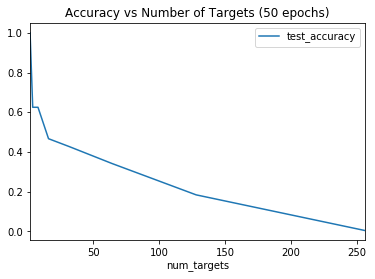

In [15]:
avt = []
for target_count in accuracy_v_targets_results:
    for result in target_count['results']:
        avt.append({
            'num_targets': target_count['num_targets'],
            'epoch': result['epoch'],
            'train_loss': result['train_loss'],
            'val_loss': result['val_loss'],
            'test_accuracy': result['test_accuracy']
            
        })
avt_frame = pd.DataFrame(avt)
avt_frame.loc[avt_frame.epoch == 20].plot(x='num_targets', y='test_accuracy', title='Accuracy vs Number of Targets (50 epochs)')

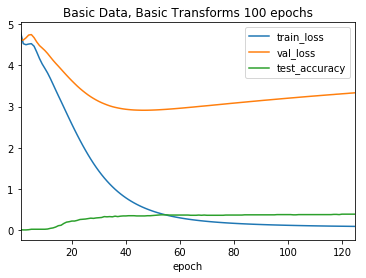

In [16]:
bdbt = pd.DataFrame(basic_data_basic_transforms['results'])
bdbt = bdbt[['epoch', 'train_loss', 'val_loss', 'test_accuracy']]
bdbt = bdbt.set_index('epoch')
bdbt.plot(title='Basic Data, Basic Transforms 100 epochs')

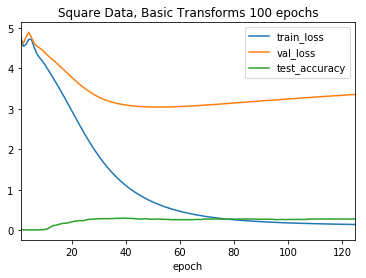

In [17]:
sdbt = pd.DataFrame(square_data_basic_transforms['results'])
sdbt = sdbt[['epoch', 'train_loss', 'val_loss', 'test_accuracy']]
sdbt = sdbt.set_index('epoch')
sdbt.plot(title='Square Data, Basic Transforms 100 epochs')

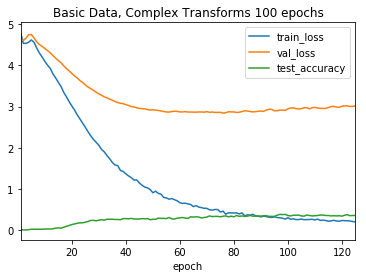

In [18]:
bdct = pd.DataFrame(basic_data_complex_transforms['results'])
bdct = bdct[['epoch', 'train_loss', 'val_loss', 'test_accuracy']]
bdct = bdct.set_index('epoch')
bdct.plot(title='Basic Data, Complex Transforms 100 epochs')

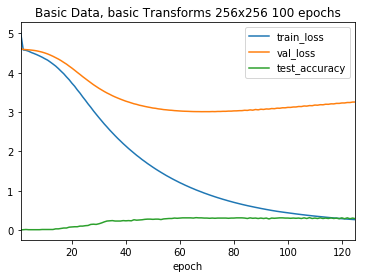

In [19]:
hdbt = pd.DataFrame(highres_data_basic_transforms['results'])
hdbt = hdbt[['epoch', 'train_loss', 'val_loss', 'test_accuracy']]
hdbt = hdbt.set_index('epoch')
hdbt.plot(title='Basic Data, basic Transforms 256x256 100 epochs')